# Retail Promotion Classification-Prediction Problem
## Vasundhara Bagchi, Elizabeth Slesarev, and Paul Beltran 

Through this project, we are aiming to use retail sales data to understand how the stores could run a personalized and targeted promotional campaigns based on customers' purchasing patterns in different categories. 

This project would allow retail stores, particularly one without a lot of resources dedicated to promotional material, to optimize their promotional campaigns by identifying the most effective customer profiles to target with their marketing efforts. This approach can save retailers significant resources and effort by avoiding a standarized approach to promotions, which can be less effective and less efficient. Instead, stores can target specific customer segments based on their preferences in shopping categories, past purchasing behaviors, and other factors to maximize the effectiveness of their promotions.

**Part 1:**

Our initial problem statement focuses on predicting whether or not we should market to a customer based on the amount of money they spent in a certain category when focusing on promotional material for that category. However, we soon run into issues regarding [] and have to take a different approach to tackling this overall task. 

**Part 2:**

Our updated problem statement now focuses on a predictive model for shopper segmentation, where shoppers are grouped into distinct categories based on their preferences and purchase patterns. Eg: Technology enthusiasts, food connoisseurs, fashion-conscious individuals, and beauty enthusiasts.
This segmentation would help businesses optimize marketing strategies through targeted promotional campaigns and personalized recommendations to ultimately increase customer retention while optimizing their resources.

### About the dataset 
This particular dataset contains data from various age groups and genders several categories from 10 shopping malls in Istanbul, Turkey. 

Data Source: https://www.kaggle.com/datasets/mehmettahiraslan/customer-shopping-dataset

### Step 1: Data Cleaning and Preprocessing

Imports

In [105]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split, 
    cross_val_score,
    StratifiedKFold, 
    KFold
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
)

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier


### Description of the features: 

1. invoice_no: Invoice number. Nominal. A combination of the letter 'I' and a 6-digit integer uniquely assigned to each operation. <br><br>
2. customer_id: Customer number. Nominal. A combination of the letter 'C' and a 6-digit integer uniquely assigned to each operation.<br><br>
3. gender: String variable of the customer's gender.<br><br>
4. age: Positive Integer variable of the customers age.<br><br>
5. category: String variable of the category of the purchased product.<br><br>
6. quantity: The quantities of each product (item) per transaction. Numeric.<br><br>
7. price: Unit price. Numeric. Product price per unit in Turkish Liras (TL).<br><br>
8. payment_method: String variable of the payment method (cash, credit card or debit card) used for the transaction.<br><br>
9. invoice_date: Invoice date. The day when a transaction was generated.<br><br>
10. shopping_mall: String variable of the name of the shopping mall where the transaction was made.<br><br>

### Reading in the data 
We read in the data source via pandas and visualize it to see the columns present and determine which ones will be useful for our purposes. 

In [106]:
df = pd.read_csv('customer_shopping_data.csv')
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


### Feature Engineering

After looking over the data, we use domain knowledge to recognize that there were certain features that would not have any real impact on shopper's shopping patterns. We therefore drop these columns.
For our purposes in this problem, we are not using 'invoice_no', 'customer_id', 'payment_method', 'invoice_date', data attributes from the dataset. 

We also want to restrict this demonstration to a couple of the main categories, so we are dropping the other categories, including Toys, Souveniers, Books, Shoes. 

In [107]:
# grabbing columns that are useful and dropping all else
df.drop(['invoice_no', 'customer_id', 'payment_method', 'invoice_date'], axis=1, inplace=True)

# dropping rows we dont care about, like toys

df.drop(df[df['category'] == 'Toys'].index, inplace = True)
df.drop(df[df['category'] == 'Souvenir'].index, inplace = True)
df.drop(df[df['category'] == 'Books'].index, inplace = True)
df.drop(df[df['category'] == 'Shoes'].index, inplace = True)



We notice that there is a price column and a quantity column, but that is not as meaningful as a total price column which will be an useful feature in our problem. We are thus calculating the new feature, **total price**, by multiplying the price and quantity columns. Once we add in this new feature, we drop the price and quantity columns as they do not provide us any new information. 

In [108]:
# recalculating price column to include totals
df['total_price'] = (df['price'] * df['quantity'])
df.drop(['quantity', 'price'], axis=1, inplace=True)
df.head()

,gender,age,category,shopping_mall,total_price
0,Female,28,Clothing,Kanyon,7502.00
2,Male,20,Clothing,Metrocity,300.08
5,Female,28,Clothing,Forum Istanbul,7502.00
6,Female,49,Cosmetics,Istinye Park,40.66
7,Female,32,Clothing,Mall of Istanbul,1200.32


Finally, we also want to know how many data points there are for each category to get a better sense of the spread of our dataset.

In [109]:
df['category'].value_counts()

Clothing           34487
Cosmetics          15097
Food & Beverage    14776
Technology          4996
Name: category, dtype: int64

It looks like clothing is the majority class whereas Technology is the minority class. 

### Visualizing the cleaned data 

One of the first pieces we want to visualize and compare is the total amount of money spent by females vs. men.

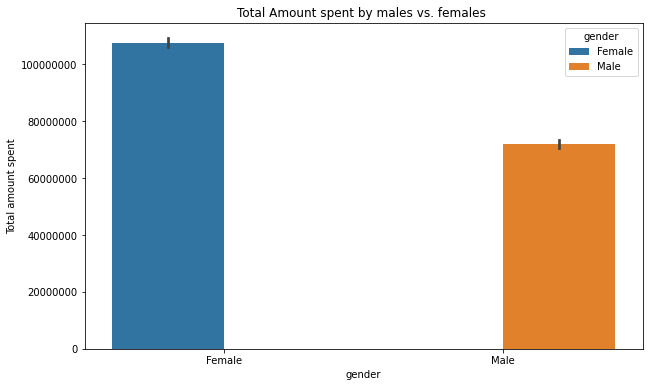

In [110]:
plt.figure(figsize=(10,6))
sns.barplot(df,x='gender',y='total_price',hue = 'gender',estimator = sum)
plt.ylabel('Total amount spent')
plt.title('Total Amount spent by males vs. females ')
plt.ticklabel_format(style='plain',axis='y')
plt.show()

It is evident that the overall total amount of money spent by females is considerably higher. 

Next, we want to comapare the amount of money spent per category by males vs. females 

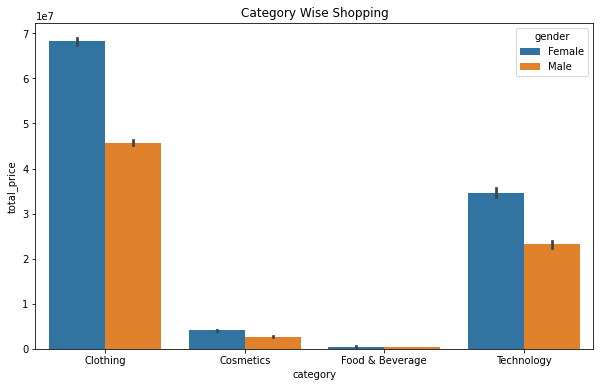

In [111]:
plt.figure(figsize=(10,6))
sns.barplot(df,x='category',y='total_price',hue = 'gender',estimator = sum)
plt.title('Category Wise Shopping')
plt.show()

It looks like the total amount of money spent in clothing, cosmetics, and technology by females is considerably higher than the total amount of money spent by men in those categories, but we want to see if this same trend follows for the average amount of money spent by females vs. males in each of these categories. 

**Calculating average amount of money spent by females vs. males in each of these categories:**

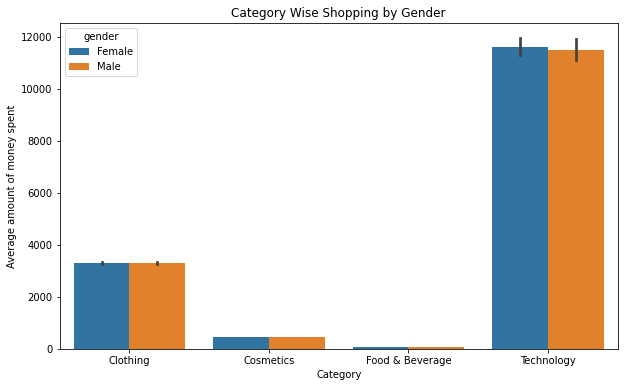

In [112]:
plt.figure(figsize=(10,6))
ax = sns.barplot(df,x='category',y='total_price',hue = 'gender',estimator = 'mean')
ax.set(xlabel='Category',
       ylabel='Average amount of money spent',
       title='Category Wise Shopping by Gender')
plt.show()

In [113]:
# checking average price spent by gender per category
avg_price_spent_per=df.groupby(['gender','category'], as_index=False)['total_price'].mean()
avg_age_per=df.groupby(['gender','category'], as_index=False)['age'].mean()
print(avg_price_spent_per)
print("\n",avg_age_per)

   gender         category   total_price
0  Female         Clothing   3304.846775
1  Female        Cosmetics    448.376245
2  Female  Food & Beverage     57.396933
3  Female       Technology  11630.308621
4    Male         Clothing   3306.475999
5    Male        Cosmetics    452.312985
6    Male  Food & Beverage     57.637718
7    Male       Technology  11509.875931

    gender         category        age
0  Female         Clothing  43.381948
1  Female        Cosmetics  43.571665
2  Female  Food & Beverage  43.489209
3  Female       Technology  43.249581
4    Male         Clothing  43.449946
5    Male        Cosmetics  43.594160
6    Male  Food & Beverage  43.155727
7    Male       Technology  43.544417


We quickly find a couple of things: 
1.  There is a noticeable amount of difference between males and females in total amount spent per category
2. There is a noticeable amount of difference between average spending from category to category 
3. There is very little difference in when comparing males vs. females **within** each category. For example, for the Technology category, Males spent an average of 11509.88 Lira wheras females spent 11630.31 Lira and in the Clothing category, males spent an average of 3306.48  Lira whereas females spent an average of 3304.85 Lira. 

There lack of variation in our data will become a problem as we will find out later 

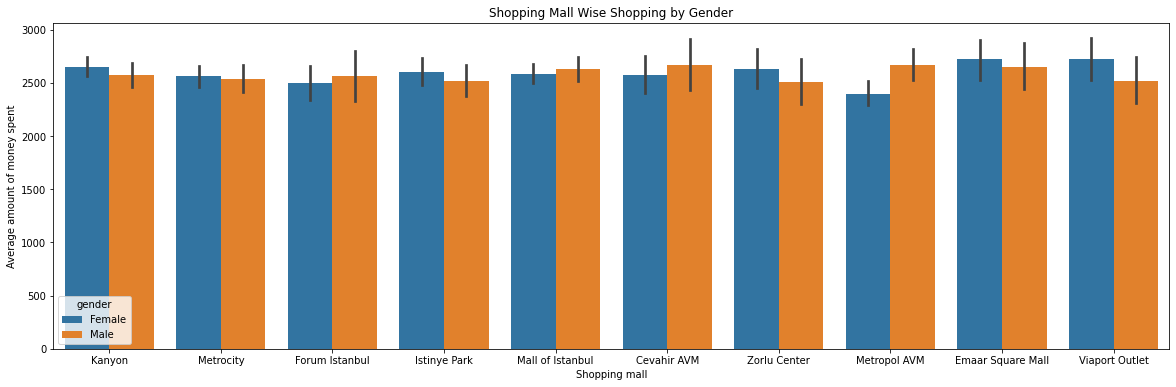

In [143]:
plt.figure(figsize=(20,6))
ax = sns.barplot(df,x='shopping_mall',y='total_price',hue = 'gender',estimator = 'mean')
ax.set(xlabel='Shopping mall',
       ylabel='Average amount of money spent',
       title='Shopping Mall Wise Shopping by Gender')
plt.show()

In [142]:
avg_price_spent_per=df.groupby(['gender','shopping_mall'], as_index=False)['total_price'].mean()
print(avg_price_spent_per)

    gender      shopping_mall  total_price
0   Female        Cevahir AVM  2578.274630
1   Female  Emaar Square Mall  2721.922403
2   Female     Forum Istanbul  2498.865477
3   Female       Istinye Park  2601.940877
4   Female             Kanyon  2652.917047
5   Female   Mall of Istanbul  2588.465487
6   Female          Metrocity  2565.397838
7   Female       Metropol AVM  2399.639890
8   Female     Viaport Outlet  2723.107971
9   Female       Zorlu Center  2628.558746
10    Male        Cevahir AVM  2666.947484
11    Male  Emaar Square Mall  2652.309208
12    Male     Forum Istanbul  2567.935761
13    Male       Istinye Park  2516.635455
14    Male             Kanyon  2572.807329
15    Male   Mall of Istanbul  2626.392354
16    Male          Metrocity  2540.795903
17    Male       Metropol AVM  2670.127212
18    Male     Viaport Outlet  2517.975887
19    Male       Zorlu Center  2509.945500


There is very little difference in when comparing males vs. females **within** for each shopping mall as well.  

# Part 1: Tackling the Initial Problem Statement 

### Creating class labels for our dataset 

After visualizing and understanding our dataset, we will now be creating class labels for our dataset. We want to have 3 labels - Yes, No, and Maybe which represent if we should market to this person based on their shopping habits - i.e amount of money spent in a particular category. 

Our cutoffs of creating each of these labels will be based on total cost percentiles per category - 


1. **Yes** - This person's total cost in a certain category is more than the 75 percentile of total money spent in that certain category, therfore, we will defintely want to market to these people. 


2. **Maybe** - This person's total cost in a certain category is less than the 75 percentile but more than the 25 percentile of total money spent in that certain category, therfore, we will may want to market to these people, but will want to give higher priority to people who have spent more money. 


3. **No** -  This person's total cost in a certain category is less than the 25 percentile but more than the median of total money spent in that certain category, therfore, we do not want to market to these people and conserve our resources instead. 

In [114]:
df.groupby(['gender','category'], as_index=False)['total_price'].describe()

gender  0     Female
        1     Female
        2     Female
        3     Female
        4       Male
              ...   
max     3    26250.0
        4     7502.0
        5     1016.5
        6     130.75
        7    26250.0
Length: 80, dtype: object

In [115]:
df.groupby(['gender','category'], as_index=False)['age'].describe()

gender  0    Female
        1    Female
        2    Female
        3    Female
        4      Male
              ...  
max     3      69.0
        4      69.0
        5      69.0
        6      69.0
        7      69.0
Length: 80, dtype: object

Now that we have found the 25th, 50th, and 75th percentiles. We use the rules above to assign class labels. 

In [116]:
# creating the class label
# label -> ['maybe', 'no', 'yes']
def assignNewLabels(row):
    # for book shoppers
    if row['category'] == "Technology" and row["total_price"] > 16800:
        return "yes"
    elif row['category'] == "Technology" and row["total_price"] <= 4200:
        return "no"
    elif row['category'] == "Technology" and row["total_price"] > 4200.0 and row["total_price"] <= 16800:
        return "maybe"
    
    # for clothing
    elif row['category'] == "Clothing" and row["total_price"] > 4801.28:
        return "yes"
    elif row['category'] == "Clothing" and row["total_price"] <= 1200.32:
        return "no"
    elif row['category'] == "Clothing" and row["total_price"] > 1200.32 and row["total_price"] <= 4801.28:
        return "maybe"
    
    # for clothing
    elif row['category'] == "Cosmetics" and row["total_price"] > 650.56:
        return "yes"
    elif row['category'] == "Cosmetics" and row["total_price"] <= 162.64:
        return "no"
    elif row['category'] == "Cosmetics" and row["total_price"] > 162.64 and row["total_price"] <= 650.56:
        return "maybe"
    
    # for clothing
    elif row['category'] == "Food & Beverage" and row["total_price"] > 83.68:
        return "yes"
    elif row['category'] == "Food & Beverage" and row["total_price"] <= 20.92:
        return "no"
    elif row['category'] == "Food & Beverage" and row["total_price"] > 20.92 and row["total_price"] <= 83.68:
        return "maybe"

In [117]:
df['Should_We_Market'] = df.apply(lambda row: assignNewLabels(row), axis=1)
df.head()

,gender,age,category,shopping_mall,total_price,Should_We_Market
0,Female,28,Clothing,Kanyon,7502.00,yes
2,Male,20,Clothing,Metrocity,300.08,no
5,Female,28,Clothing,Forum Istanbul,7502.00,yes
6,Female,49,Cosmetics,Istinye Park,40.66,no
7,Female,32,Clothing,Mall of Istanbul,1200.32,no


We now have our new class labels that our models will now try to predict. 

### Starting the Machine Learning Process 
**One Hot Encoding**

We are creating one hot encoded labels for each gender and category features as we are doing multilclass classification. We chose to opt in for this as opposed to just integer labels like 1, 2, 3, 4 corresponding to each category because we do not want there to be assumed ordinal relationship between the categories. 

In [118]:
df_dummy = pd.get_dummies(df[['gender', 'category', 'age', 'total_price', 'shopping_mall']])
df_dummy.head()


,age,total_price,gender_Female,gender_Male,category_Clothing,category_Cosmetics,category_Food & Beverage,category_Technology,shopping_mall_Cevahir AVM,shopping_mall_Emaar Square Mall,shopping_mall_Forum Istanbul,shopping_mall_Istinye Park,shopping_mall_Kanyon,shopping_mall_Mall of Istanbul,shopping_mall_Metrocity,shopping_mall_Metropol AVM,shopping_mall_Viaport Outlet,shopping_mall_Zorlu Center
0,28,7502.00,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,20,300.08,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0
5,28,7502.00,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
6,49,40.66,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
7,32,1200.32,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


**Min-max normalization**

We normalize our age and price features to ensure uniformity and ensure that they are all within the same range, [0,1]


In [119]:

# Normalizing the ages
min_age = df_dummy['age'].min()
max_age = df_dummy['age'].max()

# Apply min-max normalization to the 'age' column
df_dummy['normalized_age'] = (df_dummy['age'] - min_age) / (max_age - min_age)
df_dummy.drop(['age'], axis=1, inplace=True)



In [120]:
# Normalize the prices

min_price = df_dummy['total_price'].min()
max_price = df_dummy['total_price'].max()

# Apply min-max normalization to the 'price' column
df_dummy['normalized_price'] = (df_dummy['total_price'] - min_price) / (max_price - min_price)
df_dummy.drop(['total_price'], axis=1, inplace=True)



In [121]:
df_dummy.head()

,gender_Female,gender_Male,category_Clothing,category_Cosmetics,category_Food & Beverage,category_Technology,shopping_mall_Cevahir AVM,shopping_mall_Emaar Square Mall,shopping_mall_Forum Istanbul,shopping_mall_Istinye Park,shopping_mall_Kanyon,shopping_mall_Mall of Istanbul,shopping_mall_Metrocity,shopping_mall_Metropol AVM,shopping_mall_Viaport Outlet,shopping_mall_Zorlu Center,normalized_age,normalized_price
0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0.196078,0.285648
2,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0.039216,0.011235
5,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.196078,0.285648
6,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0.607843,0.001350
7,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0.274510,0.045536


## Running the Models

We are working with a 80/20 train test split for all of our models. 

We start with a Gaussian Naive Bayes. We chose this model because []

### Gaussian Naive Bayes with labels = yes or no or maybe

In [122]:
X = df_dummy
y = df.Should_We_Market

print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=125
)

(69356, 18) (69356,)


Accuracy: 0.6008506343713956
F1 Score: 0.6575598917743605


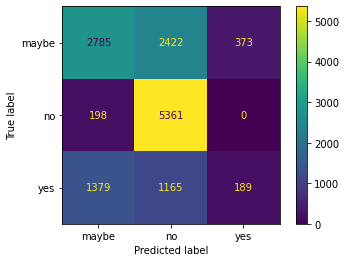

In [123]:
# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)


cm = confusion_matrix(y_test, y_pred, labels=["maybe", "no", "yes"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["maybe", "no", "yes"])
disp.plot();

# interpret results in writeup using https://www.v7labs.com/blog/confusion-matrix-guide

We can see that accuracy is low, and we realize further that this is wrong for the following reasons.

List reasons here: 
Now we will repurpose our statement to classify shopper's spending categories based on spending habits and gender and age.

# Part 2: Updated Problem Statement 

## Random Forest Classification for Feature Selection

We first take a step back and create one hot-encodings with the features we want once more. 

In [124]:
df_dummy = pd.get_dummies(df[['gender', 'age', 'total_price', 'shopping_mall']])
df_dummy.head()

,age,total_price,gender_Female,gender_Male,shopping_mall_Cevahir AVM,shopping_mall_Emaar Square Mall,shopping_mall_Forum Istanbul,shopping_mall_Istinye Park,shopping_mall_Kanyon,shopping_mall_Mall of Istanbul,shopping_mall_Metrocity,shopping_mall_Metropol AVM,shopping_mall_Viaport Outlet,shopping_mall_Zorlu Center
0,28,7502.00,1,0,0,0,0,0,1,0,0,0,0,0
2,20,300.08,0,1,0,0,0,0,0,0,1,0,0,0
5,28,7502.00,1,0,0,0,1,0,0,0,0,0,0,0
6,49,40.66,1,0,0,0,0,1,0,0,0,0,0,0
7,32,1200.32,1,0,0,0,0,0,0,1,0,0,0,0


Normalizing the ages to ensure uniformity and bring them to the same range, [0,1] 

In [125]:
# Normalizing the ages
min_age = df_dummy['age'].min()
max_age = df_dummy['age'].max()

# Apply min-max normalization to the 'age' column
df_dummy['normalized_age'] = (df_dummy['age'] - min_age) / (max_age - min_age)

# Normalize the prices
min_price = df_dummy['total_price'].min()
max_price = df_dummy['total_price'].max()

# Apply min-max normalization to the 'price' column
df_dummy['normalized_price'] = (df_dummy['total_price'] - min_price) / (max_price - min_price)
df_dummy.drop(['total_price', 'age'], axis=1, inplace=True)
df_dummy.head()




,gender_Female,gender_Male,shopping_mall_Cevahir AVM,shopping_mall_Emaar Square Mall,shopping_mall_Forum Istanbul,shopping_mall_Istinye Park,shopping_mall_Kanyon,shopping_mall_Mall of Istanbul,shopping_mall_Metrocity,shopping_mall_Metropol AVM,shopping_mall_Viaport Outlet,shopping_mall_Zorlu Center,normalized_age,normalized_price
0,1,0,0,0,0,0,1,0,0,0,0,0,0.196078,0.285648
2,0,1,0,0,0,0,0,0,1,0,0,0,0.039216,0.011235
5,1,0,0,0,1,0,0,0,0,0,0,0,0.196078,0.285648
6,1,0,0,0,0,1,0,0,0,0,0,0,0.607843,0.001350
7,1,0,0,0,0,0,0,1,0,0,0,0,0.274510,0.045536


In [126]:
X = df_dummy
y = df.category

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

rf_classifier.fit(X_train, y_train)

# Get feature importances
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = importances.argsort()[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {X.columns[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. Feature normalized_price (0.9843110372549524)
2. Feature normalized_age (0.013057406927066535)
3. Feature gender_Female (0.00028952688955515276)
4. Feature gender_Male (0.0002840372816461375)
5. Feature shopping_mall_Cevahir AVM (0.00022172243648007261)
6. Feature shopping_mall_Metrocity (0.0002194576151020334)
7. Feature shopping_mall_Viaport Outlet (0.00021654143372355403)
8. Feature shopping_mall_Forum Istanbul (0.00021630071080814048)
9. Feature shopping_mall_Istinye Park (0.00021088526966657361)
10. Feature shopping_mall_Metropol AVM (0.00020296630653846877)
11. Feature shopping_mall_Mall of Istanbul (0.00020091088418423866)
12. Feature shopping_mall_Zorlu Center (0.00019412166764470903)
13. Feature shopping_mall_Emaar Square Mall (0.0001933424455714976)
14. Feature shopping_mall_Kanyon (0.00018174287706040137)


According to this dataset, gender and shopping mall dont make a big difference in classififcation whcih lines up with our earlier observations (mean spending is the same per category for males and females), so let’s drop these and try Naive Bayes again


### Gaussian Naive Bayes with new labels based on categories

In [127]:
# dropping useless features according to Random Forest
df_dummy.drop(['gender_Female', 'gender_Male', 'shopping_mall_Mall of Istanbul',
               'shopping_mall_Metrocity', 'shopping_mall_Forum Istanbul', 'shopping_mall_Viaport Outlet',
               'shopping_mall_Emaar Square Mall', 'shopping_mall_Kanyon', 'shopping_mall_Istinye Park',
               'shopping_mall_Zorlu Center', 'shopping_mall_Cevahir AVM', 'shopping_mall_Metropol AVM'], axis=1, inplace=True)

In [128]:
X = df_dummy
y = df.category

print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=125
)

(69356, 2) (69356,)


Accuracy: 0.8121575638733491
F1 Score: 0.8137622111213028


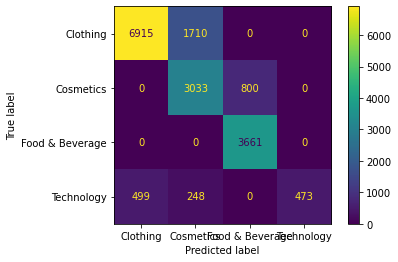

In [129]:
# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)


cm = confusion_matrix(y_test, y_pred, labels=["Clothing", "Cosmetics", "Food & Beverage", "Technology"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Clothing", "Cosmetics", "Food & Beverage", "Technology"])
disp.plot()



# interpret results in writeup using https://www.v7labs.com/blog/confusion-matrix-guide

Accuracy is a lot better because of .... 

### Stratified K-fold cross validation for Naive Bayes without Gender and Shopping Mall features

In [130]:
kf = StratifiedKFold(n_splits=10, random_state=40, shuffle=True) 
accscore = []
classifier2 = GaussianNB()


for train_index , test_index in kf.split(X, y):
    X_train , X_test = X.iloc[train_index],X.iloc[test_index]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
     
    classifier2.fit(X_train, y_train.values.ravel())
    Y_pred = classifier2.predict(X_test)

     
    acc2 = accuracy_score(y_test, Y_pred)
    accscore.append(acc2)
     
avgscore = sum(accscore)/10
 
print("Accuracy from each fold = \n" + str(accscore))
print("\nAverage accuracy = \n" + str(avgscore))
print()


Accuracy from each fold = 
[0.81199538638985, 0.8184832756632064, 0.8171856978085352, 0.8114186851211073, 0.8124279123414071, 0.828719723183391, 0.8152847873107426, 0.8116798846431147, 0.8108147080028839, 0.813410237923576]

Average accuracy = 
0.8151420298387814



Hmmm, seems like the gender and shopping mall features really did not matter in the long run. Lets try another classification technique instead!
(To learn more about stratified k-fold cross validation, visit here for more info: https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/)

### Neural Networks:

In [131]:
# one hot encode the category classes
df_dummy = pd.get_dummies(df[['gender', 'age', 'total_price']])
df_y_dummy = pd.get_dummies(df[['category']])
df_y_dummy.head()

,category_Clothing,category_Cosmetics,category_Food & Beverage,category_Technology
0,1,0,0,0
2,1,0,0,0
5,1,0,0,0
6,0,1,0,0
7,1,0,0,0


In [132]:
# Normalizing the ages
'''
min_age = df_dummy['age'].min()
max_age = df_dummy['age'].max()

# Apply min-max normalization to the 'age' column
df_dummy['normalized_age'] = (df_dummy['age'] - min_age) / (max_age - min_age)

# Normalize the prices
min_price = df_dummy['total_price'].min()
max_price = df_dummy['total_price'].max()

# Apply min-max normalization to the 'price' column
df_dummy['normalized_price'] = (df_dummy['total_price'] - min_price) / (max_price - min_price)

# drop converted columns
df_dummy.drop(['total_price', 'age'], axis=1, inplace=True)
'''
df_dummy.head()


,age,total_price,gender_Female,gender_Male
0,28,7502.00,1,0
2,20,300.08,0,1
5,28,7502.00,1,0
6,49,40.66,1,0
7,32,1200.32,1,0


In [133]:
# Split the data into features and target
X = df_dummy
y = df['category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [134]:
model = MLPClassifier(hidden_layer_sizes=(16, 8), activation='relu', solver='adam', max_iter=1500, random_state=42)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')

Test accuracy: 0.9562


As you can see, the neural network performed very well, with a test accuracy of 89.65%. Compare this to the accuracy of the Naive Bayes classifier of 81.5% and a massive difference is evident.

To learn more about Neural Networks, I highly recommend 3b1b's video series: https://www.youtube.com/watch?v=aircAruvnKk

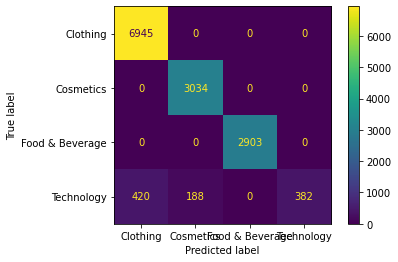

In [135]:
y_pred = model.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred, labels=["Clothing", "Cosmetics", "Food & Beverage", "Technology"])
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["Clothing", "Cosmetics", "Food & Beverage", "Technology"])
disp2.plot();

### KNN 

Accuracy:1.0
F1 score:1.0
Confusion Matrix:


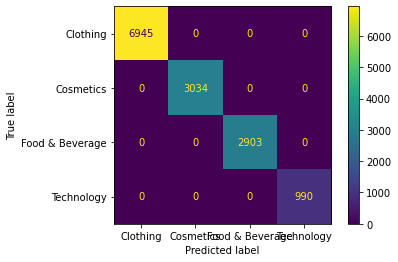

In [136]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 50, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
Y_pred = classifier.predict(X_test)

acc = accuracy_score(y_test, Y_pred)
print ("Accuracy:" + str(acc))
f1 = f1_score(Y_pred, y_test, average="weighted")
print ("F1 score:" + str(f1))
print("Confusion Matrix:")


cm = confusion_matrix(y_test, Y_pred, labels=["Clothing", "Cosmetics", "Food & Beverage", "Technology"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Clothing", "Cosmetics", "Food & Beverage", "Technology"])
disp.plot()



In [137]:
#KNN - 10 fold validation 

kf = StratifiedKFold(n_splits=10,random_state=40, shuffle=True) 
accscore = []
fscorearr = []
classifier = KNeighborsClassifier(n_neighbors = 50, metric = 'minkowski', p = 2)

for train_index , test_index in kf.split(X, y):
    X_train , X_test = X.iloc[train_index],X.iloc[test_index]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
     
    #classifier.fit(X_train,y_train)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
     
    acc = accuracy_score(y_test, y_pred)
    accscore.append(acc)
    fscore = f1_score(y_test, y_pred, average=None)
    fscorearr.append(fscore)

     
avgscore = sum(accscore)/10
avgfscore = sum(fscore)/10
 
print("Accuracy from each fold using KNN with 35 neighbors = " + str(accscore))
print("Average accuracy using KNN with 35 neighbors = " + str(avgscore))
print("Average fscore using KNN with 35 neighbors = " + str(avgscore))
print()

Accuracy from each fold using KNN with 35 neighbors = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Average accuracy using KNN with 35 neighbors = 1.0
Average fscore using KNN with 35 neighbors = 1.0



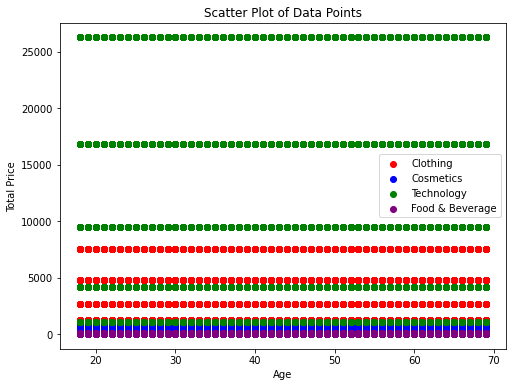

In [138]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a dictionary to map class labels to colors
class_colors = {'Clothing': 'red', 'Cosmetics': 'blue', 'Technology': 'green', 'Food & Beverage': 'purple'}

# Plotting the scatter plot
plt.figure(figsize=(8, 6))

for category, color in class_colors.items():
    class_data = df[df['category'] == category]
    plt.scatter(class_data['age'], class_data['total_price'], color=color, label=category)

plt.xlabel('Age')
plt.ylabel('Total Price')
plt.title('Scatter Plot of Data Points')
plt.legend()
plt.show()


Accuracy vs. K 

In [139]:
# Split the data into features and target
X = df_dummy
y = df['category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Maximum accuracy:- 1.0 at K = 0


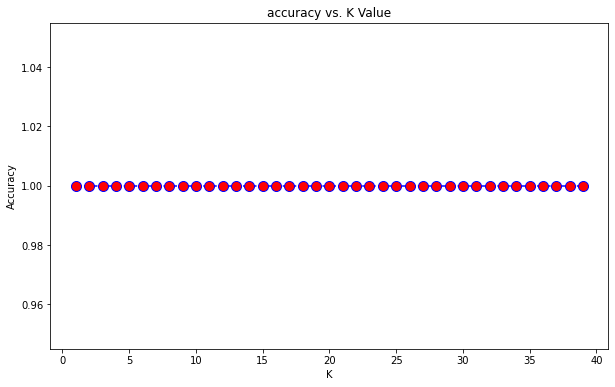

In [140]:
acc = []
# Will take some time
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

## Conclusion

## Policy Recommendation 
The performance of these models could be improved by: 